# Practica 3

## Aprendizaje Automático

Miguel Ibáñez González   
Alexandru Marius Platon  
Pareja: 14

# Wind Energy Prediction

The aim of this problem is to predict the hourly wind power generation for a wind farm.

Attribute Information:

Data for two years are given in two csv files with a first column with a datetime and the rest with headers

`['10u', '10v', '2t', 'sp', '100u', '100v', 'vel10', 'vel100', 'targ']`


where

* `targ` is the wind energy production normalized to a [0., 1.] range.
* `10u,10v, 100u, 100v` are the U (west-east) and V (south-north) wind components in m/s at heights 10 m and 100 m.
* `vel10,vel100` are the absolute wind speeds in m/s at heights 10 and 100 meters.
* `2t,sp` are surface temperature and pressure.

In order to simplify our computations, we are going to drop the `10, 10v, vel10` columns, but add three new variables:

* the sine and cosine of the wind at 100 meters.
* the cube of the `vel100` variable, as theoretically the energy of the wind that hits the blades is proportional to the cube of wind speed.

Thus our final eight variables must be:

* `100u, 100v`, the U (west-east) and V (south-north) wind components in m/s at height 100 m.
* `vel100`, the absolute wind speeds in m/s at height 100 meters.
* `vel100_3`, the cube of `vel100`.
* `s100, c100`, the sine and cosine of the wind direction at height 100 meters.
* `2t,sp`, surface temperature and pressure.

We are going to work with data fromn the years 2016, 2017 and 2018. Years 2016 and 2017 will be used for train and validation, and the year 2018 for test.

In [1]:
%matplotlib inline

In [2]:
import time
import sys

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import median_abs_deviation

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Cargamos los datos

Leemos los datos y modificamos las columnas como se ha pedido.

In [3]:
data_dir = 'D:\\OneDrive - Universidad Autonoma de Madrid\\sbc_2023\\'
data_dir = 'D:\\OneDrive - UAM\\sotav\\'
data_dir = './we/'

d_years = {}
for yy in ['2016', '2017', '2018']:
    f_name = 'df_' + yy + '.csv'
    d_years[yy] = pd.read_csv(data_dir + f_name, sep=',', parse_dates=True, index_col=0)

    # Remove NaNs and modify columns
    d_years[yy].dropna(inplace=True)
    d_years[yy]['s100'] = d_years[yy]['100v']/d_years[yy]['vel100']
    d_years[yy]['c100'] = d_years[yy]['100u']/d_years[yy]['vel100']
    d_years[yy]['vel100_3'] = d_years[yy]['vel100']**3
    d_years[yy] = d_years[yy].drop(columns=['10u', '10v', 'vel10'])

## Familiarización con los datos

Realizamos un análisis de los datos, midiendo estadísticas básicas, haciendo diagramas de cajas y de dispersión y analizando correlaciones de los atributos con el objetivo.

### Análisis descriptivo

Medimos algunas estadísticas básicas de los datos que son de nuestro interés, como el tamaño de la muestra, la media, desviación típica y minimos y máximos. Esto se hace con el objetivo de detectar alguna posible incosistencia en los datos.  
A primera vista solo vemos que a pesar de que el objetivo **targ** debería estar normalizado entre 0 y 1, en nigún año se llega a alcanzar el máximo. 

In [4]:
display("2016", d_years['2016'].describe().loc[['count', 'mean', 'std', 'min', 'max']])
display("2017", d_years['2017'].describe().loc[['count', 'mean', 'std', 'min', 'max']])
display("2018", d_years['2018'].describe().loc[['count', 'mean', 'std', 'min', 'max']])

'2016'

2t            sp         100u         100v       vel100  \
count  8784.000000   8784.000000  8784.000000  8784.000000  8784.000000   
mean    284.601271  95950.397733     0.001086     0.515967     6.364048   
std       5.414618    769.800555     5.418696     4.539365     3.119077   
min     271.341797  93148.187500   -13.399642   -12.669861     0.138182   
max     306.323730  98034.562500    20.653137    16.700782    21.213394   

              targ         s100         c100     vel100_3  
count  8784.000000  8784.000000  8784.000000  8784.000000  
mean      0.161248     0.029908    -0.036476   467.287599  
std       0.200789     0.664159     0.746178   742.257350  
min       0.000000    -1.000000    -0.999999     0.002638  
max       0.882954     1.000000     1.000000  9546.198592

'2017'

2t            sp         100u         100v       vel100  \
count  8760.000000   8760.000000  8760.000000  8760.000000  8760.000000   
mean    284.955208  96028.316581    -0.208570     0.448940     6.299779   
std       5.496982    654.850948     5.484560     4.374436     3.125607   
min     271.820801  92531.625000   -18.075775   -10.544312     0.051946   
max     305.882324  97923.375000    25.269330    18.329265    26.538709   

              targ         s100         c100      vel100_3  
count  8760.000000  8760.000000  8760.000000   8760.000000  
mean      0.152738     0.016144    -0.031734    457.869454  
std       0.188621     0.667673     0.743679    761.978450  
min       0.000000    -1.000000    -1.000000      0.000140  
max       0.920468     1.000000     1.000000  18691.293752

'2018'

2t            sp         100u         100v       vel100  \
count  8760.000000   8760.000000  8760.000000  8760.000000  8760.000000   
mean    284.616904  95737.279245    -0.018663     0.843951     6.917011   
std       5.640436    814.969070     5.655384     5.069265     3.246999   
min     271.416260  91614.375000   -14.568741   -12.694214     0.069787   
max     305.095703  97579.125000    16.623805    20.076727    20.090648   

              targ         s100         c100     vel100_3  
count  8760.000000  8760.000000  8760.000000  8760.000000  
mean      0.177838     0.045756    -0.016008   565.771802  
std       0.209765     0.666433     0.744064   752.085174  
min       0.000000    -1.000000    -1.000000     0.000340  
max       0.899912     0.999999     1.000000  8109.271289

### Diagrama de cajas

Normalizamos los datos con MinMax, incluidos los **targ** porque ya vimos que no están normalizados en el rango [0, 1]. De esta forma se pueden visualizar estando en la misma escala. Lo hacemos para el conjunto de datos de entrenamiento, separándolo por años para detectar posibles cambios significativos.

Text(0.5, 1.0, '2017')

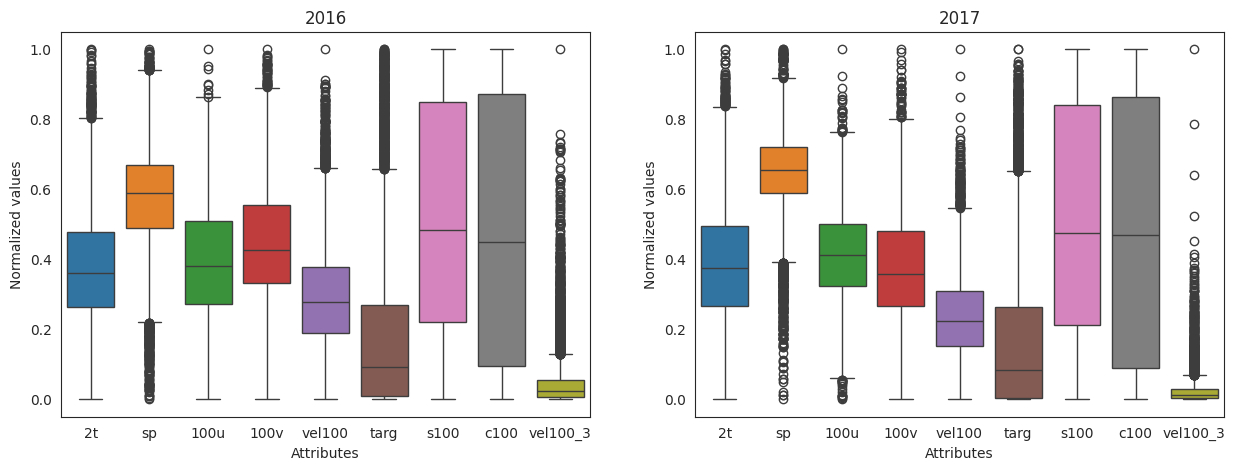

In [5]:
d_years_norm = {}
for yy in ['2016', '2017', '2018']:
    d_years_norm[yy] = (d_years[yy] - d_years[yy].min()) / (d_years[yy].max() - d_years[yy].min())
    
plt.figure(figsize=(15, 5))
sns.set_style("white")
sns.set_context(font_scale=1.5)
plt.subplot(1, 2, 1)
ax = sns.boxplot(data=d_years_norm['2016'])
ax.set_xlabel('Attributes')
ax.set_ylabel('Normalized values')
ax.set_title('2016')
plt.subplot(1, 2, 2)
ax = sns.boxplot(data=d_years_norm['2017'])
ax.set_xlabel('Attributes')
ax.set_ylabel('Normalized values')
ax.set_title('2017')


### Histogramas y diagramas de dispersión

En este caso utilizamos también los datos normalizados para generar los diagramas. El objetivo es detectar si hay alguna evolución similar para algún par de variables y ver de forma más detallada la concentración de los datos en cada atributo.

2016


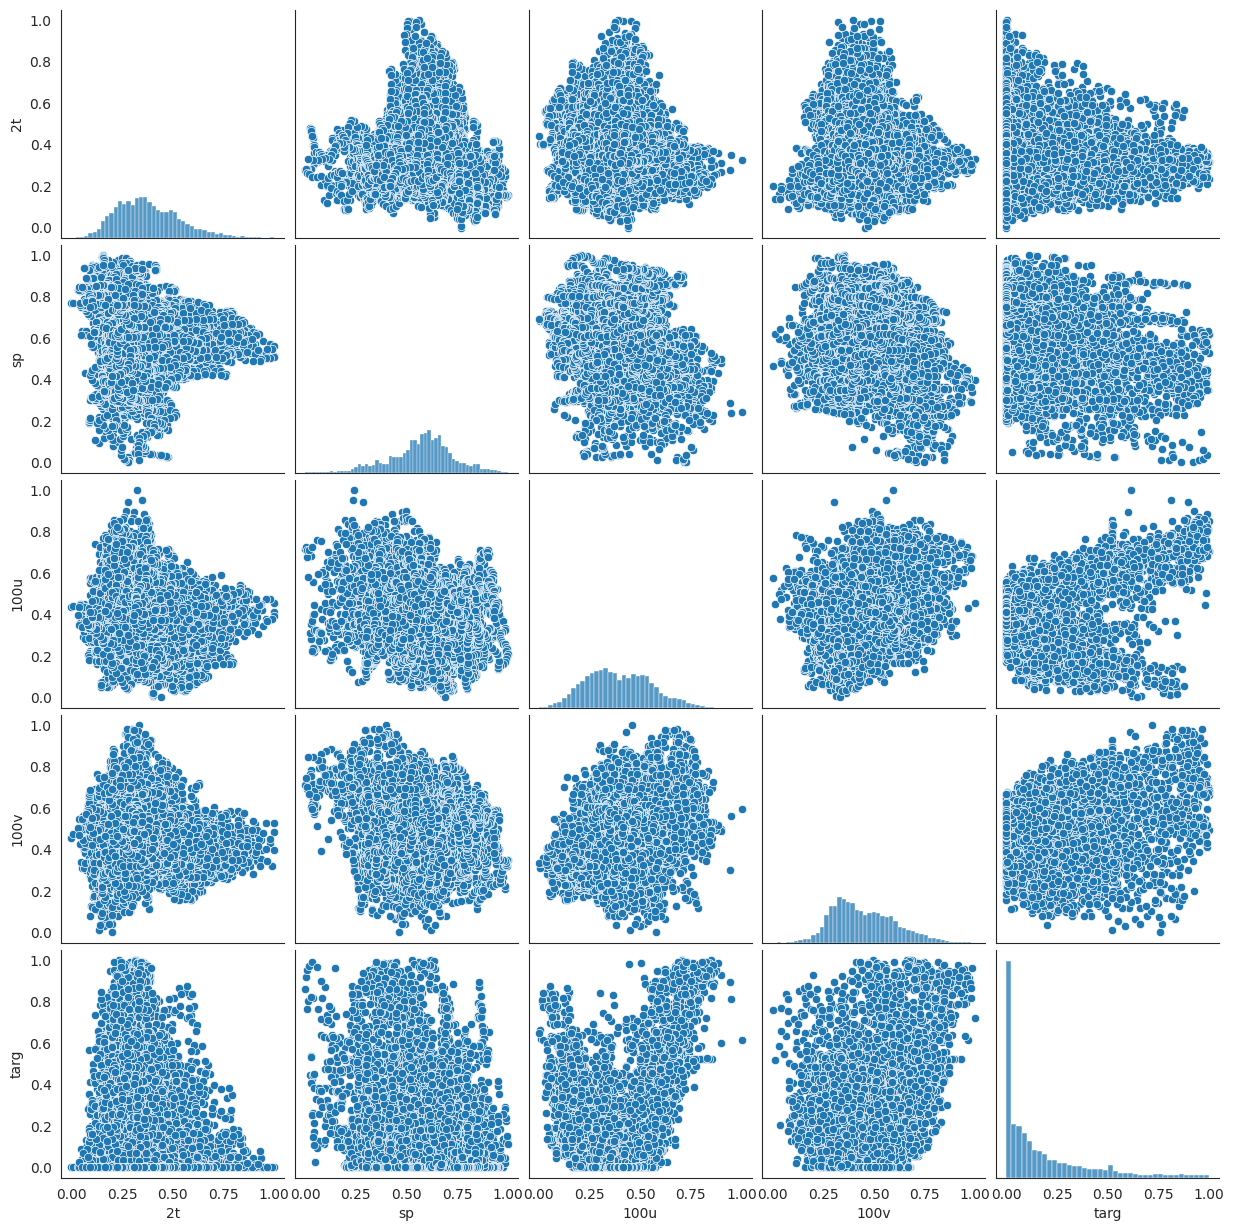

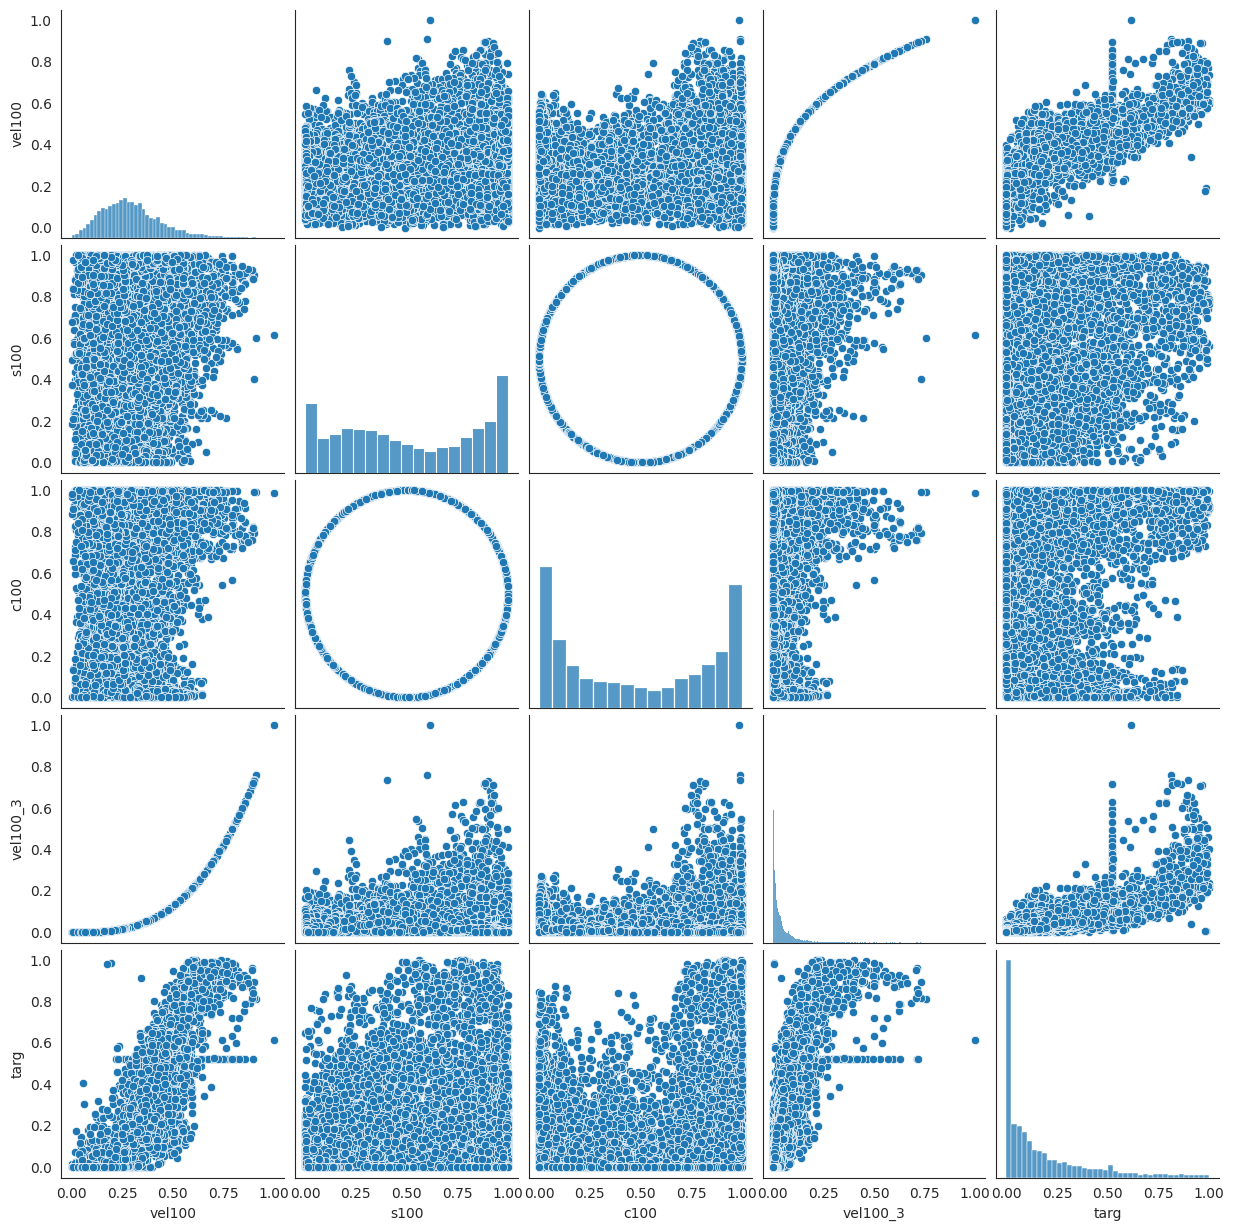

2017


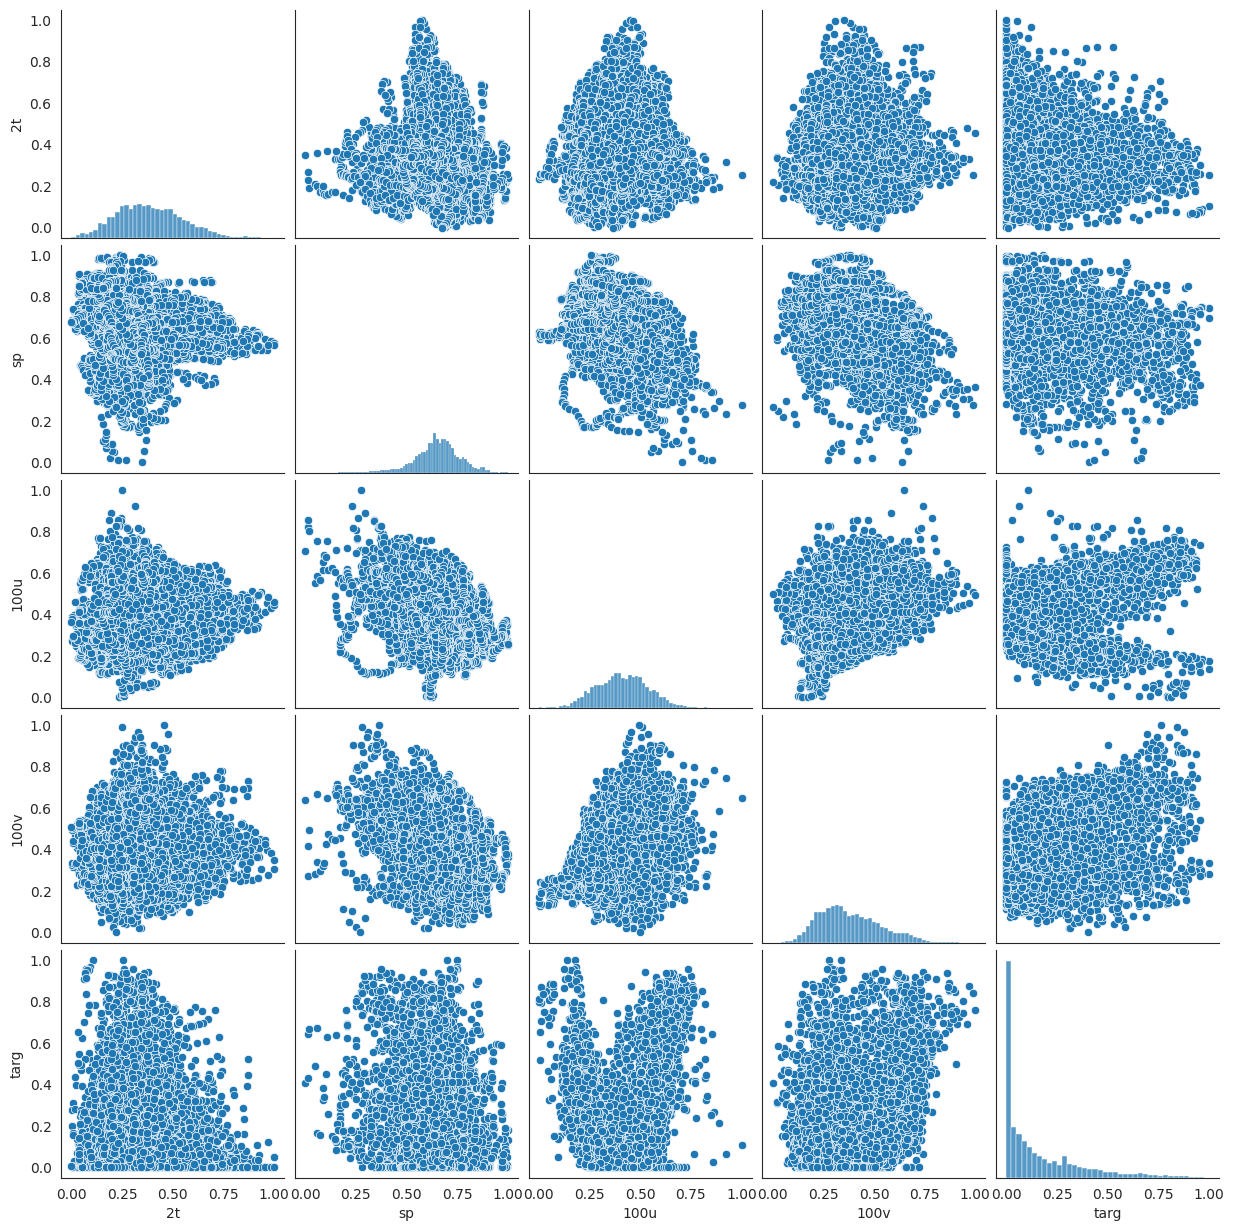

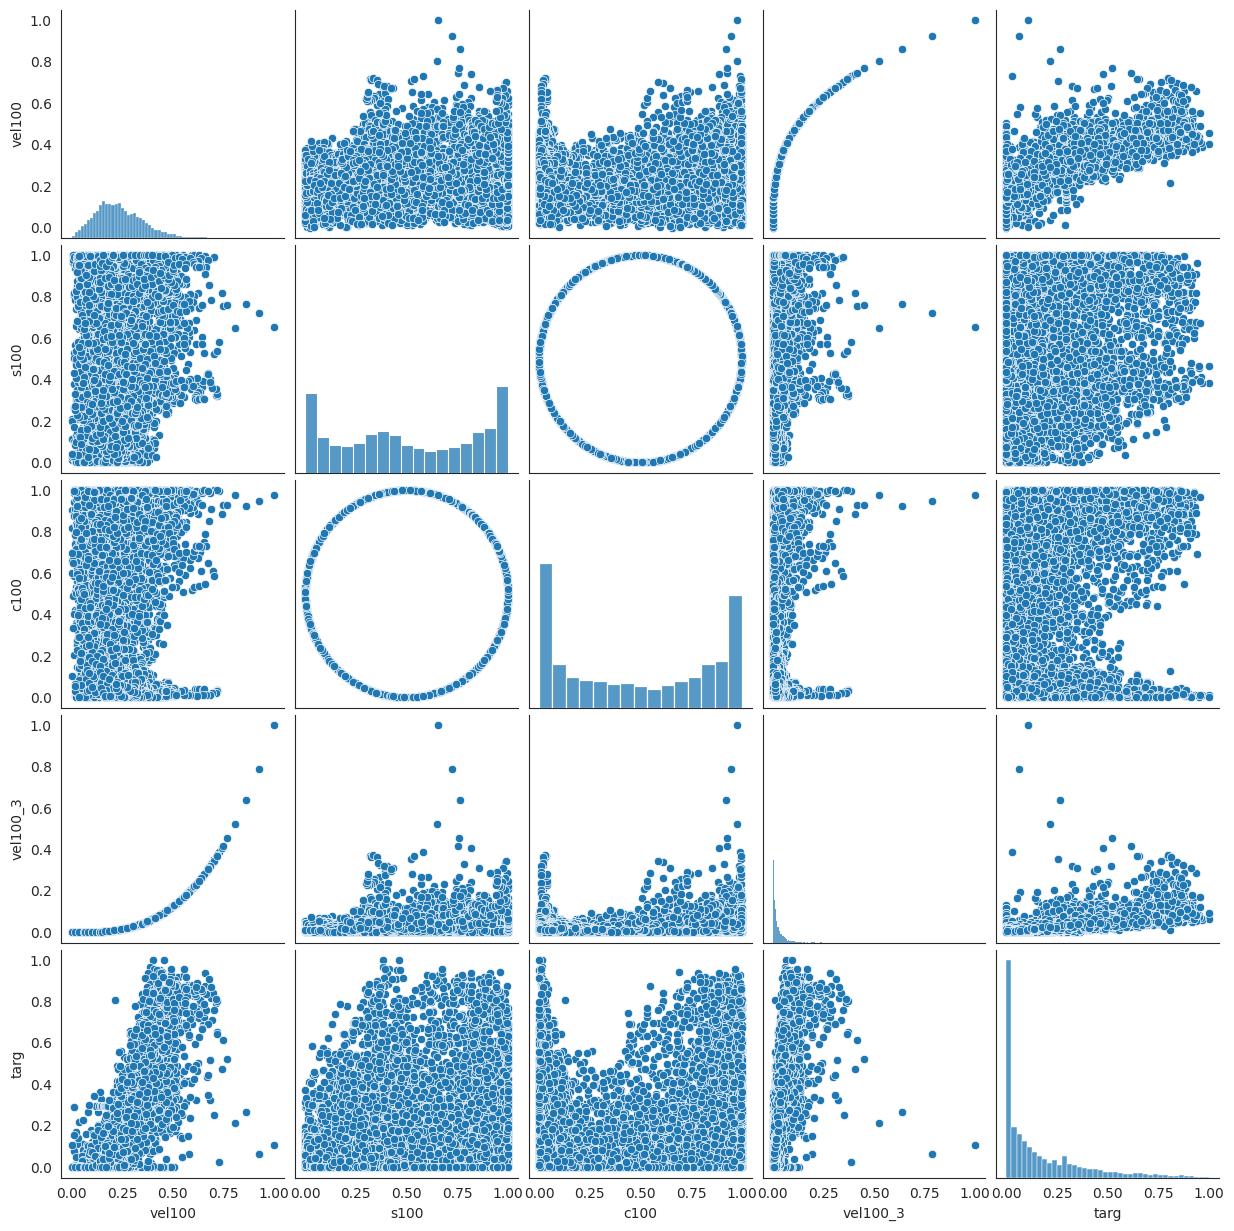

In [6]:
d_years_attr = {}
d_years_targ = {}
for yy in ['2016', '2017']:
    d_years_targ[yy] = d_years_norm[yy]['targ']
    d_years_attr[yy] = d_years_norm[yy].drop(columns=['targ'])

for yy in ['2016', '2017']:
    print(yy)
    selected_columns = list(d_years_attr[yy].columns[:4]) + [d_years_targ[yy].name]
    sns.pairplot(d_years_norm[yy][selected_columns])
    plt.show()
    selected_columns = list(d_years_attr[yy].columns[4:8]) + [d_years_targ[yy].name]
    sns.pairplot(d_years_norm[yy][selected_columns])
    plt.show()


### Correlaciones

Calculamos las correlaciones y los mostramos como un mapa de calor de manera ordenada con respecto a **targ** para observar de manera más fácil los atributos más correlacionados.

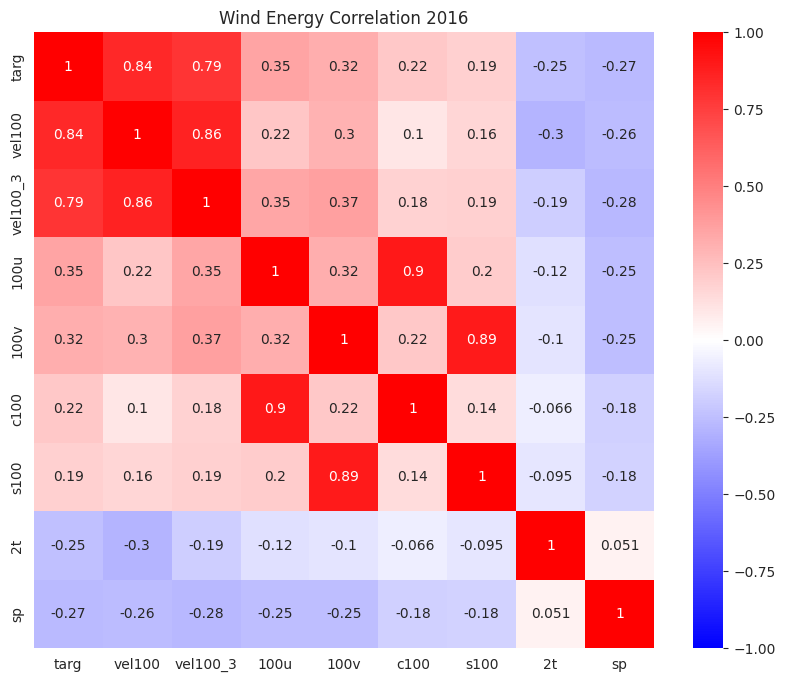

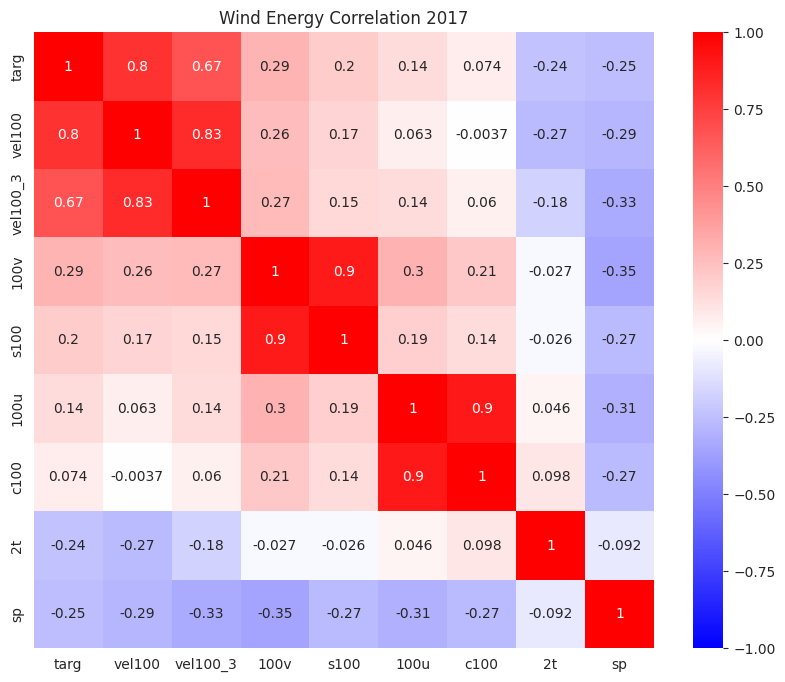

In [7]:
for yy in ['2016', '2017']:
    corr_matrix = d_years_norm[yy].corr()
    
    sorted_indices = corr_matrix['targ'].sort_values(ascending=False).index
    sorted_corr_matrix = corr_matrix.loc[sorted_indices, sorted_indices]

    cMap = plt.colormaps.get_cmap('bwr')
    
    plt.figure(figsize=(10, 8))
    plt.title('Wind Energy Correlation ' + yy)
    sns.heatmap(sorted_corr_matrix, vmin=-1., vmax=1., cmap=cMap, 
                annot=True,
                xticklabels=sorted_corr_matrix.columns,
                yticklabels=sorted_corr_matrix.index)
    plt.show()


## Conclusiones del análisis de datos

En los diagramas de cajas podemos ver que la principal diferencia entre los años 2016 y 2017 es que los datos medidos de la velocidad del viento a 100m aumentan en valor notablemente de un año al otro. Esto a su vez produce que los datos de **vel100_3** tengan valores atípicos todavía mas extremos. Sin embargo, vemos también que el atributo **targ**, que recoge los valores de energía eólica producida, cuenta con una gran cantidad de valores atípicos positivos, que podrían coincidir con picos producidos por ráfagas fuertes de viento. Otro dato relevante de targ es que, a pesar de estar normalizado en un rango de 0 a 1, el máximo nunca llega a ser 1 y además, más de la mitad de los datos se encuentran en el intervalo 0 - 0.25.

Tras analizar los resultados previos, dados por los gráficos de dispersión y las correlaciones, estos indican que los atributos más determinantes para predecir la energía final producida son la velocidad del viento a los 100 metros **(vel100)** junto con la energia teoríca que se calcula a partir de esta misma **(vel100_3)**. Estos resultados son bastante lógicos y muestran una clara correlación. Por otro lado, también vemos que la componente "norte/sur" tiene el doble de correlación que la "este/oeste" y que la presión y temperatura en la superficie tienen una correlación más negativa que todos los demás atributos.

# Regresor MLP

Tal como se indica usaremos los datos de 2016 y 2017 en conjunto para entrenar nuestro modelo y seleccionar los hiperparámetros, mientras que los datos de prueba serán los de 2018. Además, para disminuir los costes de la búsqueda de hiperparámetros, usaremos unicamente 2 folds para CV. 
Empezaremos directamente con la búsqueda de hyperparámetros en Grid 



## GridSearchCV MLP

Construimos un Grid para buscar los hiperparámetros que mejores resultados dan para el MLP. Para ello, iremos variando los parámetros alfa, la funcion de activación, el número de neuronas y distribución de capas, la tasa de aprendizaje inicial y el número de iteraciones. En el pipeline también montamos un MinMaxScaler para noramlizar tanto los atributos como el objetivo.

In [8]:
d_years_attr = {}
d_years_targ = {}
for yy in ['2016', '2017', '2018']:
    if yy not in d_years_attr:
        d_years_targ[yy] = d_years[yy]['targ']
        d_years_attr[yy] = d_years[yy].drop(columns=['targ'])

x = pd.concat([d_years_attr['2016'], d_years_attr['2017']])
y = pd.concat([d_years_targ['2016'], d_years_targ['2017']])

n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

mlpr =  MLPRegressor(
    activation='relu',
    solver='adam', 
    early_stopping=True,
    tol=1.e-10)

regr = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler()),
    ('mlp', mlpr)
])

y_transformer = MinMaxScaler()
inner_estimator = TransformedTargetRegressor(
    regressor=regr,
    transformer=y_transformer
)

l_alpha = [10.**k for k in range(-4, 1)]
l_hidden_layer_sizes = [
    (32, 32, 32), 
    (64, 64, 64), 
    (64, 128), 
    (256,), 
    (128, 64)
]
l_learning_rate_init = [1e-2, 1e-3, 1e-4]
l_max_iter = [10000, 15000, 20000]
l_activation = ['relu', 'tanh']

param_grid = {
    'regressor__mlp__alpha': l_alpha,
    'regressor__mlp__hidden_layer_sizes': l_hidden_layer_sizes,
    'regressor__mlp__learning_rate_init': l_learning_rate_init,
    'regressor__mlp__max_iter': l_max_iter,
    'regressor__mlp__activation': l_activation,
}

cv_estimator = GridSearchCV(
    inner_estimator, 
    param_grid=param_grid, 
    cv=kf, 
    scoring='neg_mean_absolute_error',
    return_train_score=True, 
    refit=True, 
    n_jobs=-1
)

t_0 = time.time()
cv_estimator.fit(x, y)
t_1 = time.time()
print("\nmlp_grid_search_time: %.2f mins" % ((t_1 - t_0) / 60.))

f_cv = 'mlp_grid_search_results.joblib'
joblib.dump(cv_estimator, f_cv)

print('Best parameters:')
print('best_alpha = %.10f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('best_hidden_layer_sizes =', cv_estimator.best_params_['regressor__mlp__hidden_layer_sizes'])
print('best_learning_rate_init =', cv_estimator.best_params_['regressor__mlp__learning_rate_init'])
print('best_max_iter =', cv_estimator.best_params_['regressor__mlp__max_iter'])
print('best_activation =', cv_estimator.best_params_['regressor__mlp__activation'])
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

df_cv = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_cv = df_cv.sort_values(by='rank_test_score')
df_cv = df_cv.reset_index(drop=True)
display(df_cv[['param_regressor__mlp__alpha', 
               'param_regressor__mlp__hidden_layer_sizes', 
               'param_regressor__mlp__learning_rate_init', 
               'param_regressor__mlp__max_iter',
               'param_regressor__mlp__activation',
               'mean_test_score', 
               'std_test_score']].head(5))


mlp_grid_search_time: 3.54 mins
Best parameters:
best_alpha = 0.0001000000
best_hidden_layer_sizes = (64, 64, 64)
best_learning_rate_init = 0.001
best_max_iter = 15000
best_activation = relu
best_cv_mae = 0.059


param_regressor__mlp__alpha param_regressor__mlp__hidden_layer_sizes  \
0                       0.0001                             (64, 64, 64)   
1                       0.0001                             (64, 64, 64)   
2                       0.0001                             (64, 64, 64)   
3                       0.0001                             (64, 64, 64)   
4                       0.0010                                (64, 128)   

   param_regressor__mlp__learning_rate_init  param_regressor__mlp__max_iter  \
0                                    0.0010                           15000   
1                                    0.0010                           20000   
2                                    0.0010                           10000   
3                                    0.0100                           20000   
4                                    0.0001                           15000   

  param_regressor__mlp__activation  mean_test_score  std_test_score  
0                             relu        -0.058935        0.000360  
1                             relu        -0.059001        0.000128  
2                             relu        -0.059056        0.000591  
3                             relu        -0.059161        0.000075  
4                             relu        -0.059184        0.000374

## Eficiencia del mejor MLP en entrenamiento

Se hacen predicciones en CV con 2 folds para el mejor mlp encontrado para 20 pruebas. Con 20 iteraciones obtenemos un valor razonable para calcular la media y mediana de los valores predichos por el mejor mlp para diferentes casos.

Progress: 100.00%
mae_mean_pred     0.062
mae_median_pred     0.061


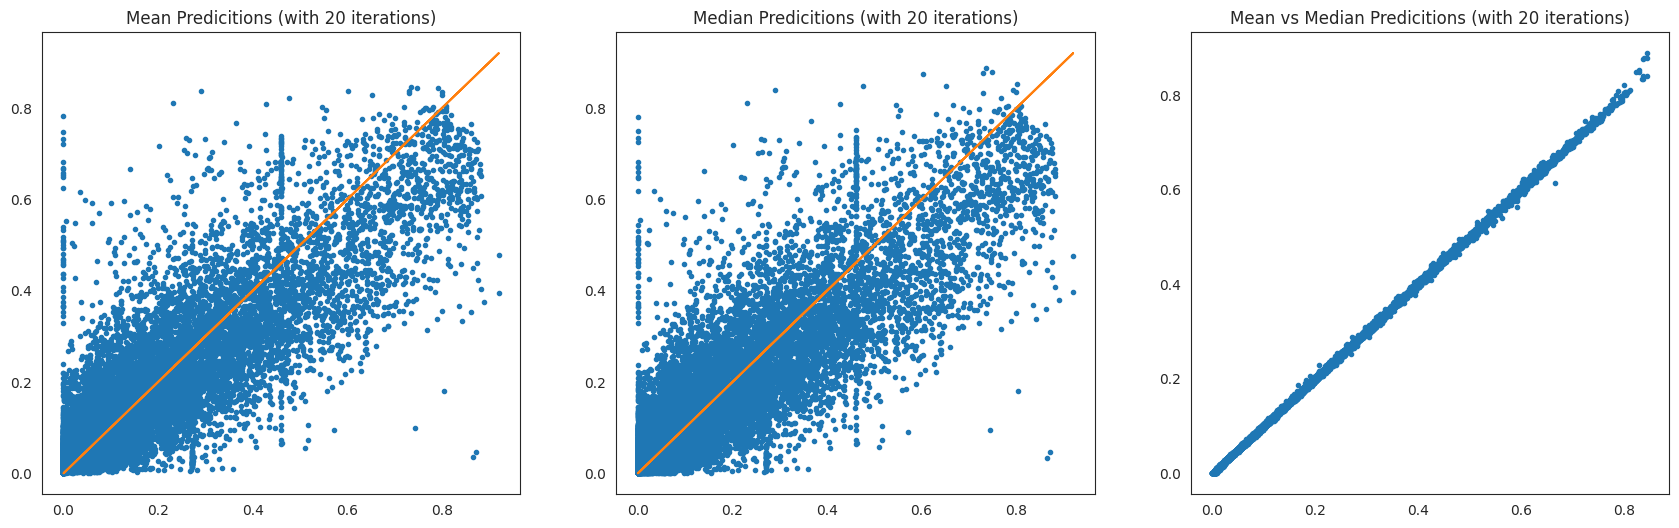

In [9]:
l_preds = []
best_mlp = cv_estimator.best_estimator_
n_folds = 2
n_iterations = 20


sys.stdout.write("Progress: 0.00%")
sys.stdout.flush()
for i in range(n_iterations):
    kf = KFold(n_splits=n_folds, shuffle=False)
    y_pred = np.clip(cross_val_predict(best_mlp, x, y, cv=kf, n_jobs=-1), 0, 1)
    l_preds.append(y_pred)
    
    progress = (i + 1) / n_iterations * 100
    sys.stdout.write(f"\rProgress: {progress:.2f}%")
    sys.stdout.flush()

print()
a_preds = np.array(l_preds).T
mean_y_pred = a_preds.mean(axis=1)
median_y_pred = np.median(a_preds, axis=1)

print("mae_mean_pred {0:9.3f}".format(mean_absolute_error(y, mean_y_pred)))
print("mae_median_pred {0:9.3f}".format(mean_absolute_error(y, median_y_pred)))

plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.title(f'Mean Predicitions (with {n_iterations} iterations)')
_ = plt.plot(y, mean_y_pred, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title(f'Median Predicitions (with {n_iterations} iterations)')
_ = plt.plot(y, median_y_pred, '.', y, y, '-')

plt.subplot(1, 3, 3)
plt.title(f'Mean vs Median Predicitions (with {n_iterations} iterations)')
_ = plt.plot(mean_y_pred, median_y_pred, '.')

## Eficiencia del mejor MLP en test

Probamos el mejor MLP con el conjunto de prueba para ver su desempeño en un conjunto de datos nuevo.


Evaluation in test:
MAE: 0.07012370784031646
MSE: 0.011005847297101051
R2: 0.749846304436822
MAD: 0.03996830482147587


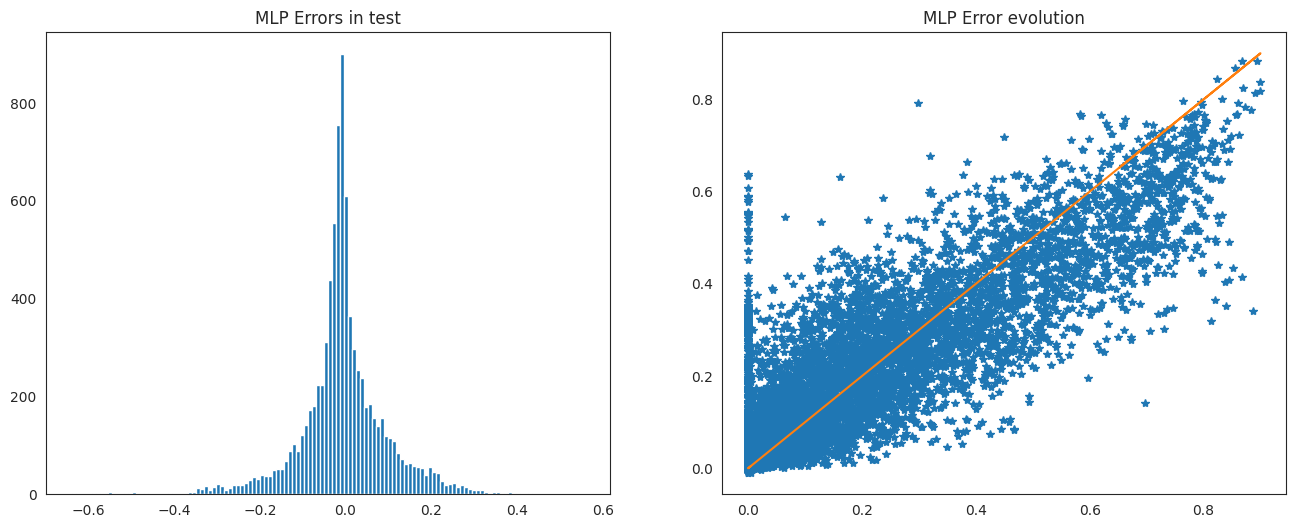

In [10]:
y_test = d_years['2018']['targ']
x_test = d_years['2018'].drop(columns=['targ'])


y_p_test = best_mlp.predict(x_test)
err = np.abs(y_test - y_p_test)
print("\nEvaluation in test:")
mae = mean_absolute_error(y_test, y_p_test)
mse = mean_squared_error(y_test, y_p_test)
r2 = r2_score(y_test, y_p_test)
mad = median_abs_deviation(y_test - y_p_test)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"MAD: {mad}")

err = y_test - y_p_test
plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("MLP Errors in test")
_ = plt.hist(err, bins=128)

plt.subplot(1,2,2)
plt.title("MLP Error evolution")
_ = plt.plot(y_test, y_p_test, '*', y_test, y_test, '-')

plt.show()

En general los resultados no parecen ser muy malos, el error es de alrededor del 7% para MAE y un 0.73 de R_2 score.

# SVR

Utilizaremos kernels Gaussianos, por lo que solo nos quedarían **tres** parametros por establecer: `C, gamma, epsilon`. Debido a los altos costes computacionales de SVR el tiempo de entrenamiento va a ser considerablemente mayor que en el caso de MLP. Nuevamente empezaremos directamente por el GridSearchCV utilizando 2 folds.

## GridSearchCV SVR

In [11]:
d_years_attr = {}
d_years_targ = {}
for yy in ['2016', '2017', '2018']:
    if yy not in d_years_attr:
        d_years_targ[yy] = d_years[yy]['targ']
        d_years_attr[yy] = d_years[yy].drop(columns=['targ'])

x = pd.concat([d_years_attr['2016'], d_years_attr['2017']])
y = pd.concat([d_years_targ['2016'], d_years_targ['2017']])

n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

svr = SVR(kernel='rbf')

regr = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler()),
    ('svr', svr)
])

y_transformer = MinMaxScaler()
inner_estimator = TransformedTargetRegressor(
    regressor=regr,
    transformer=y_transformer
)
dim = x.shape[1]
l_C     = [10.**k for k in range(-1, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-3, -7, -1)] 


param_grid = {
    'regressor__svr__C': l_C,
    'regressor__svr__epsilon': l_epsilon,
    'regressor__svr__gamma': l_gamma
}

cv_estimator = GridSearchCV(
    inner_estimator, 
    param_grid=param_grid, 
    cv=kf, 
    scoring='neg_mean_absolute_error',
    return_train_score=True, 
    refit=True, 
    n_jobs=-1
)

t_0 = time.time()
cv_estimator.fit(x, y)
t_1 = time.time()

print("\nsvr_grid_search_time: %.2f mins" % ((t_1 - t_0) / 60.))

f_cv = 'svr_grid_search_results.joblib'
joblib.dump(cv_estimator, f_cv)

print('Best parameters:')
print('best_C = %.3f' % (cv_estimator.best_params_['regressor__svr__C']))
print('best_epsilon = %.3f' % (cv_estimator.best_params_['regressor__svr__epsilon']))
print('best_gamma =', cv_estimator.best_params_['regressor__svr__gamma'])
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

df_cv = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_cv = df_cv.sort_values(by='rank_test_score')
df_cv = df_cv.reset_index(drop=True)
display(df_cv[['param_regressor__svr__C', 
               'param_regressor__svr__epsilon', 
               'param_regressor__svr__gamma',
               'mean_test_score', 
               'std_test_score']].head(5))


svr_grid_search_time: 7.69 mins
Best parameters:
best_C = 10.000
best_epsilon = 0.016
best_gamma = 8.0
best_cv_mae = 0.057


param_regressor__svr__C  param_regressor__svr__epsilon  \
0                     10.0                       0.015625   
1                      1.0                       0.015625   
2                    100.0                       0.015625   
3                     10.0                       0.015625   
4                      1.0                       0.015625   

   param_regressor__svr__gamma  mean_test_score  std_test_score  
0                          8.0        -0.056700        0.000012  
1                          8.0        -0.056904        0.000118  
2                          4.0        -0.057198        0.000034  
3                          4.0        -0.057279        0.000086  
4                          4.0        -0.057366        0.000130

## Eficiencia del mejor SVR en entrenamiento

Igual que para MLP usamos 2 folds y 20 iteraciones para calcular la media y mediana de los valores predecidos.

Progress: 100.00%
mae_mean_pred     0.069
mae_median_pred     0.069


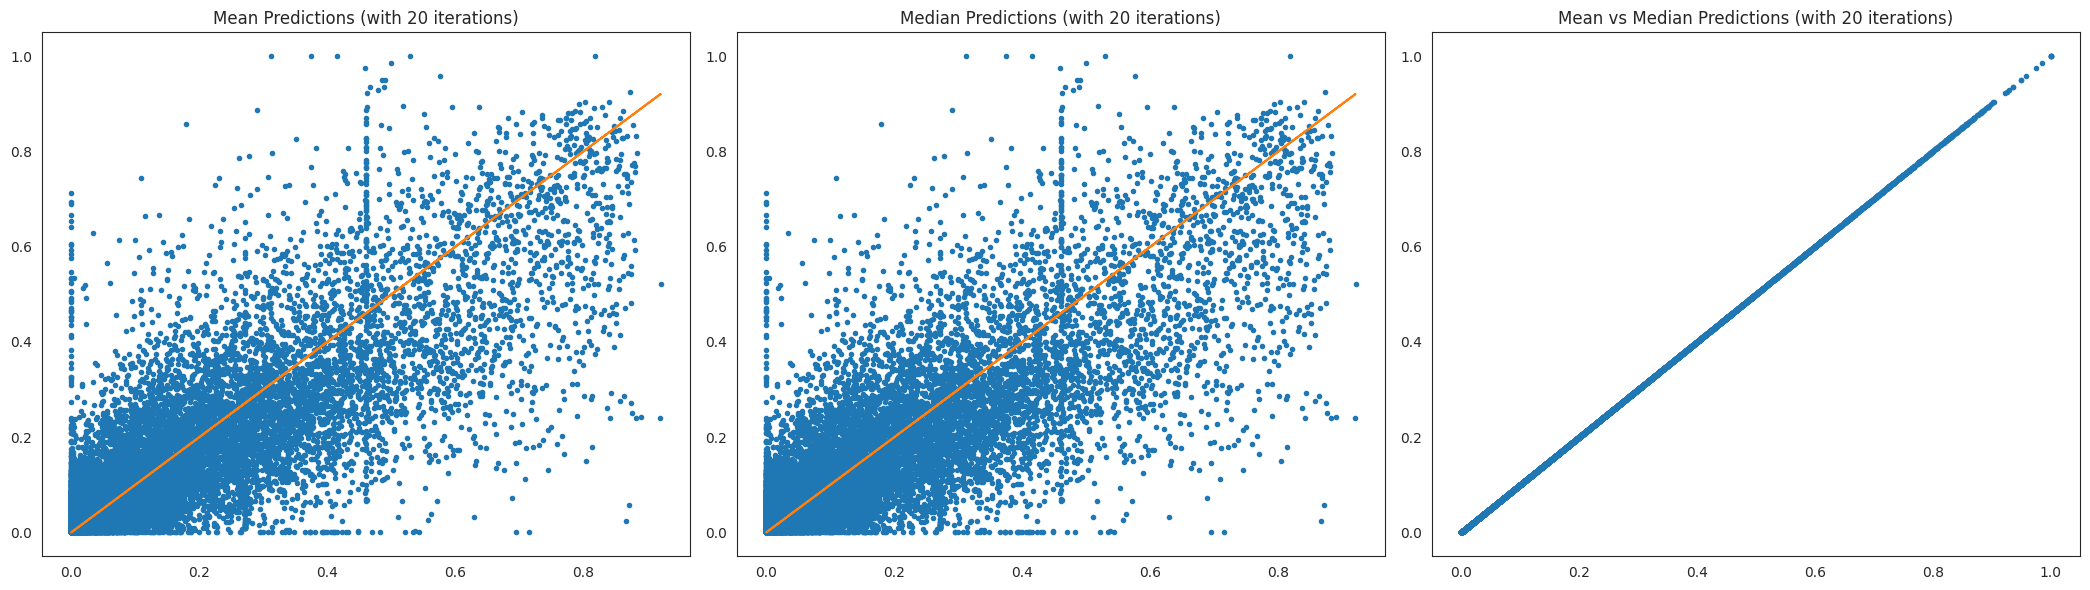

In [12]:
l_preds = []
best_svr = cv_estimator.best_estimator_
n_folds = 2
n_iterations = 20

sys.stdout.write("Progress: 0.00%")
sys.stdout.flush()

for i in range(n_iterations):
    kf = KFold(n_splits=n_folds, shuffle=False)
    y_pred = np.clip(cross_val_predict(best_svr, x, y, cv=kf, n_jobs=-1), 0, 1)
    l_preds.append(y_pred)
    
    progress = (i + 1) / n_iterations * 100
    sys.stdout.write(f"\rProgress: {progress:.2f}%")
    sys.stdout.flush()

print()
a_preds = np.array(l_preds).T
mean_y_pred = a_preds.mean(axis=1)
median_y_pred = np.median(a_preds, axis=1)

print("mae_mean_pred {0:9.3f}".format(mean_absolute_error(y, mean_y_pred)))
print("mae_median_pred {0:9.3f}".format(mean_absolute_error(y, median_y_pred)))

plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
plt.title(f'Mean Predictions (with {n_iterations} iterations)')
plt.plot(y, mean_y_pred, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title(f'Median Predictions (with {n_iterations} iterations)')
plt.plot(y, median_y_pred, '.', y, y, '-')

plt.subplot(1, 3, 3)
plt.title(f'Mean vs Median Predictions (with {n_iterations} iterations)')
plt.plot(mean_y_pred, median_y_pred, '.')

plt.tight_layout()
plt.show()

## Eficiencia del mejor SVR en Test

En este caso también usamos el mejor SVR para ver su desempeño usando el conjunto de entrenamiento.


Evaluation in test:
MAE: 0.07309562336500668
MSE: 0.01319360030251781
R2: 0.7001205100921555
MAD: 0.04074377938803353


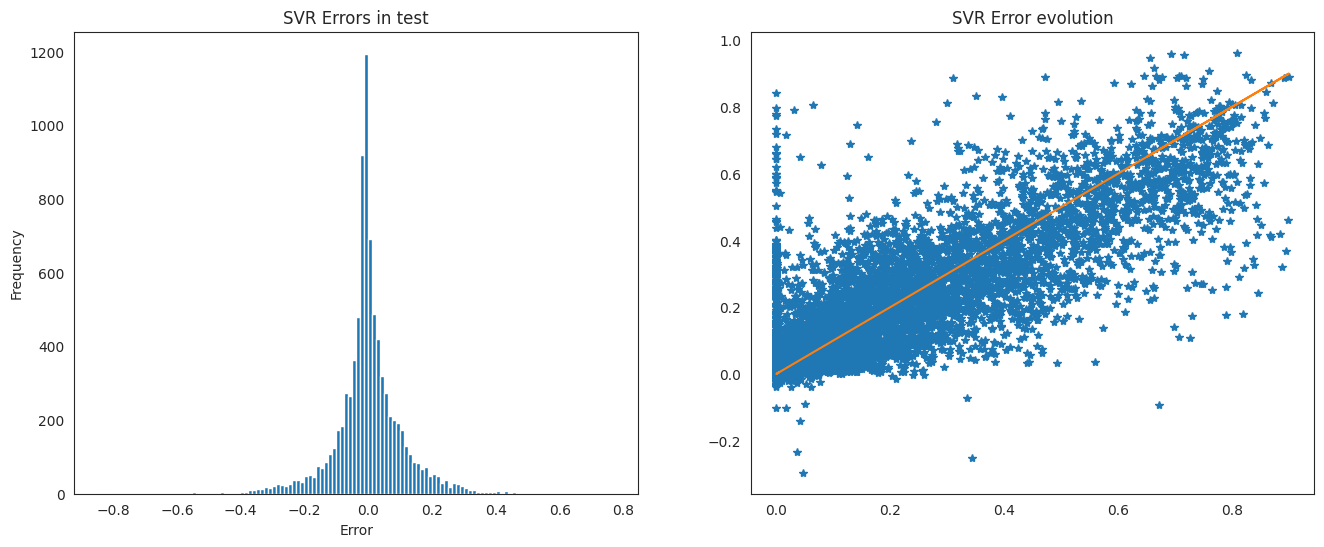

In [13]:
y_test = d_years['2018']['targ']
x_test = d_years['2018'].drop(columns=['targ'])


y_p_test = best_svr.predict(x_test)
err = np.abs(y_test - y_p_test)
print("\nEvaluation in test:")
mae = mean_absolute_error(y_test, y_p_test)
mse = mean_squared_error(y_test, y_p_test)
r2 = r2_score(y_test, y_p_test)
mad = median_abs_deviation(y_test - y_p_test)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"MAD: {mad}")

err = y_test - y_p_test
plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("SVR Errors in test")
plt.xlabel("Error")
plt.ylabel("Frequency")
_ = plt.hist(err, bins=128)

plt.subplot(1,2,2)
plt.title("SVR Error evolution")
_ = plt.plot(y_test, y_p_test, '*', y_test, y_test, '-')

plt.show()

## MLP vs SVR coparación y conclusiones and conclusions

### Evaluación de Validación Cruzada

MLP funciona ligeramente peor en términos de mean absolute error (best_cv_mae) durante la validación cruzada, con un valor de 0.059 frente al 0.057 del SVR.

### Evaluación en el conjunto de prueba  

#### MAE:  
MLP tiene un MAE de 0.0701, un poco mejor que el 0.0730 de SVR. Esto indica que las predicciones del MLP estuvieron más cerca de los valores reales.

#### MSE:  
El MLP tuvo un MSE de 0.0110, mientras que el SVR obtuvo 0.0131, lo que refleja que los errores al cuadrado fueron menores en el MLP. Esto podría ser porque el MLP fue más efectivo al manejar errores grandes.

#### R²:  
El coeficiente de determinación R² fue mejor para el MLP (0.7498) en comparación con el SVR (0.7001). Esto indica que el MLP logró explicar una mayor proporción de la variabilidad de los datos.

#### MAD:  
El MAD (desviación absoluta media) fue similar en ambos modelos, con 0.03996 para el MLP y 0.0407 para el SVR.

### Conclusión General  

Aunque ambos modelos presentan un buen desempeño, el MLP es un poco superior en términos de MAE, MSE, y R² sobre el conjunto de prueba. Esto siginifica que MLP es más efectivo al generalizar en este conjunto de datos, a pesar de la mayor complejidad del modelo y el tiempo de entrenamiento requerido.

El SVR sigue siendo una opción con un buen desempeño, pero es un poco menos preciso que el MLP en este caso. En aplicaciones donde el tiempo de ajuste y la simplicidad del modelo son los factores importantes, el SVR podría ser una alternativa mejor, pero para este conjunto de datos, el MLP es la opción buena.


#### Posibles mejoras  

Como se mencionó en el análisis inicial, en los datos del objetivo **targ**, había una gran concentración de valores que estaban muy cercanos a 0. Adicionalmente, también se vió que mas del 50% de los valores eran menores a 0.2, en un contexto en el cuál los datos estaban normalizados entre 0 y 1. Esto puede ser el causante de que ninguno de los modelos llegue a converger a valores de error inferiores al 7% en test. Una posible solución podría venir de hacer un mejor manejo de los 0s, por ejemplo eliminando una parte importante, o haciendo algún tipo de transformación adicional.